*This is a brief notebook, but it is heavily reliant on the concepts covered in the [Single Lens](SingleLens.ipynb) notebook. If you have not completed that notebook, purhaps it would be best if you did that and then came back.*

If you haven't already done so, install MulensModel before continuing with this notebook:
```bash
pip install MulensModel
```

In [1]:
# package imports (SHIFT + ENTER to run)
import numpy as np
import emcee
import MulensModel as mm
import matplotlib.pyplot as plt
import sys
import multiprocessing as mp
from IPython.display import display, clear_output
from typing import List, Tuple, Optional, Union

# development note: replace emcee with dynesty?

# The binary source model

Events matching a one-lens, two-sources model typically have lightcurves with smooth non-Paczynski shapes, such as the one in Jung et al. (2017), Figure 5, which is shown below. They are, in effect, two distinct Paczynski curves on top of each other; they do not create "sharp" perturbations from the primary Paczynski curve, like the binary-lens models typically do.

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 95%;
        text-align: center;
    }
</style>

| ![Jung 2017 Figure 5](./Assets/Jung2017-F5.jpg) | ![Jung 2017 Figure 3](./Assets/Jung2017-F3.jpg) |
| :-: | :-: |
| [Reproduction of Jung et al. (2017), Figure 5] Geometry and lightcurve of the binary-source model. *Top:* The upper panel shows the geometry of the binary-source model. Two straight lines with arrows are the source trajectories of individual source stars. The lens is located at the origin (marked by M), and the dotted circle is the angular Einstein ring. The red and blue filled circles represent the individual source positions at $\rm{HJD}'=7497$. Lengths are normalised by the Einstein radius. *Bottom:* The lower panel shows the enlarged view of the anomaly region. The two curves with different colours are best-fit binary-source models for $RI$ and $I$ passbands. The inset shows a zoom of the anomaly near $\rm{HJD}'\sim7501.4$. We note that, although we only use the $V$-band data for determining the source type, we also present the $V$-band model lightcurve to compare the colour change between passbands. | [Reproduction of Jung et al. (2017), Figure 3] Geometry and lightcurve of the binary lens model. *Top:* The upper panel shows the geometry of the binary lens model. The straight line with an arrow is the source trajectory, red closed concave curves represent the caustics, and blue filled circles (marked by $M_1$ and $M_2$) are the binary lens components. All length scales are normalised by the Einstein radius. The inset shows the general view and the major panel shows the enlarged view corresponding to the lightcurve of the lower panel. The open circle on the source trajectory is the source position at the time of observation whose size represents the source size. *Bottom:* The lower panel shows the enlarged view of the anomaly region. The inset shows a zoom of the lightcurve near $\rm{HJD}'\sim7501.4$. The curve superposed on the data is the best-fit binary lens model. |

The magnification model has the same parameterisation as the single lens model, except the flux model is a sum of two single-source magnifications multiplied by the flux of the source they are lensing:
$$ \mathbf{F}=\mathbf{A_1}F_{\rm S1}+\mathbf{A_2}F_{\rm S2}+F_{\rm B}, $$
where $\mathbf{A_1}$ and $F_{\rm S1}$ are the primary-source magnification model and flux, $\mathbf{A_2}$ and $F_{\rm S2}$ are the secondary-source magnification model and flux, $F_{\rm B}$ is the blend flux, and the models $\mathbf{A_1}$ and $\mathbf{A_2}$ share the same physical lens parameters $(D_{\rm L},\,M_{\rm L})$.

We can see the model in practice in the code cell below:

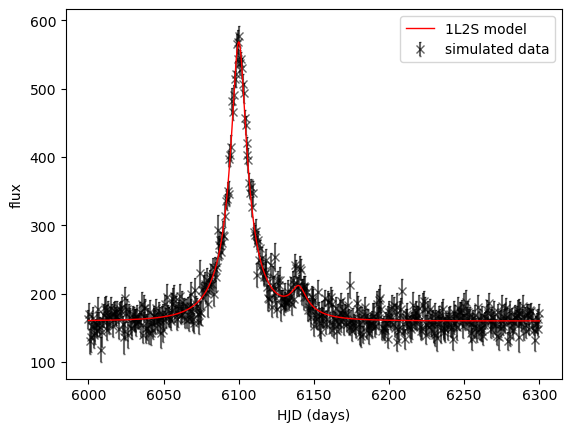

In [2]:
# A simulated binary source event

t01, u01 = 6100., 0.2  # primary source model parameters
t02, u02 = 6140., 0.2  # secondary source model parameters
t_E = 25.   # tE is not necessarily the same, due to orbital motion of the lens system, but we would expect 
            # tE to be mostly due to the relative propermotion of the lens and source systems.
flux1, flux_ratio, blend_flux = 100., 0.1, 50.
n = 500  # number of data points
time = np.linspace(6000., 6300., n)  # "data" epochs
N = 1000  # model plotting precision
T = np.linspace(6000., 6300., N)  # model time array

# building the individual magnification models for each source star
model1 = mm.Model({'t_0': t01, 'u_0': u01, 't_E': t_E})
A1 = model1.get_magnification(time)
model2 = mm.Model({'t_0': t02, 'u_0': u02, 't_E': t_E})
A2 = model2.get_magnification(time)

flux = A1 * flux1 + A2 * flux1*flux_ratio + blend_flux
flux_err = 3.0 *(np.abs(5.0 + np.random.normal(size=n)))  # flux uncertainties with mu=15 and std=3
error = flux_err * np.random.normal(size=n)     # offset the "meaasurments" by an amount that is dependent    
flux += error                                   # on the uncertainty
data = [time, flux, flux_err]

my_dataset = mm.MulensData(data, phot_fmt='flux')

plt.close(1)
plt.figure(1)

# Plot the data
plt.errorbar(time, flux, yerr=flux_err, 
             fmt='x', 
             ecolor='k', 
             capsize=1, 
             color='k', 
             alpha=0.6, 
             zorder=0,
             label='simulated data'
             )
# Plot the model
F = model1.get_magnification(T) * flux1 + model2.get_magnification(T) * flux1*flux_ratio + blend_flux
plt.plot(T, F, 
         color='r', 
         linestyle='-', 
         lw=1, 
         zorder=1, 
         label='1L2S model'
         )

plt.legend()
plt.xlabel(r'HJD (days)')
plt.ylabel(r'flux')
plt.show()

The measure of how far the data are from the model solution, scaled by the data uncertainties ($\chi^2$), is calculated using 
$$ \chi^2 = \sum\limits_i \frac{\left(F_i - x_i\right)^2} {\sigma_i^2}. $$ 
$\chi^2$ quantifies how likely a parameter set is to have generated the observed data, for a given model.

Similar to the procedure in the [Single Lens](SingleLens.ipynb) notebook, the maximum likelihood solution $(F_{\rm S1}, F_{\rm S2}, F_{\rm B})$ can therefore be found by solving for the minima of this function. As in the previous section, the minima occurs where the partial derivatives of the $\chi^2$ function are 0;
$$
    \frac{\partial\chi^2}{\partial F_{\rm S1}} = 0, 
    \frac{\partial\chi^2}{\partial F_{\rm S2}} = 0, 
    \frac{\partial\chi^2}{\partial F_{\rm B}} = 0.
$$
This linear regression problem can be written in the form
$$
\begin{matrix}
    \begin{bmatrix}
        \sum\limits_{i}\frac{A_{1,i}^{2}}{\sigma_{i}^{2}} & 
        \sum\limits_{i}\frac{A_{1,i}A_{2,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{A_{1,i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{A_{1,i}A_{2,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{A_{2,i}^{2}}{\sigma_{i}^{2}} & 
        \sum\limits_{i}\frac{A_{2,i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{A_{1,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{A_{2,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{1}{\sigma_{i}^{2}}
    \end{bmatrix}
    & \times &
    \begin{bmatrix}
        F_{\rm S1} \\ 
        F_{\rm S2} \\ 
        F_{\rm B}
    \end{bmatrix}
    & = &
    \begin{bmatrix}
        \sum\limits_{i}\frac{A_{1,i}x_{i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{A_{2,i}x_{i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{x_{i}}{\sigma_{i}^{2}}
    \end{bmatrix}
    \\
    \mathbf{B} &\times& \mathbf{\Theta} &=& \mathbf{C},
\end{matrix}
$$

which is solved following as follows:
$$ \mathbf{\Theta} = \mathbf{B}^{-1} \mathbf{C} = \frac{adj\,\mathbf{B}}{\det\mathbf{B}} \cdot \mathbf{C}. $$

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 1</h2>
    <p>Use linear regression to determine the flux of the primary source, secondary source, and blend stars. Did you get out something similar to what you put in?</p>
    <br>
    <p>You may want to consider using functions from the numpy.linalg module.</p>
    <br>
</div>

In [3]:
# objective function
def binary_source_chi2(theta: np.ndarray, 
                       model1: mm.Model, 
                       model2: mm.Model, 
                       data: List, 
                       verbose: Optional[bool] = False,
                       return_fluxes: Optional[bool] = False
                       ) -> float:
    """
    chi2 function for a binary-source, single-lens, microlensing model.
    
    Parameters
    ----------
    theta : np.ndarray
        Array of model parameters being fit.
    model1 : mm.Model
        Primary source model.
    model2 : mm.Model
        Secondary source model.
    data : list
        List of data arrays.
    verbose : bool, optional
        Default is False.
        Print the primary source flux, secondary source flux, and blend flux.

    Returns
    -------
    float
        The chi2 value.

    Notes
    -----
    The model parameters are unpacked from theta and set to the model1 and model2 parameters.
    model1 and model2 are MulensModel.Model objects; see MulensModel documentation 
    (https://rpoleski.github.io/MulensModel/) for more information.
    """
    #unpack the data
    t, flux, flux_err = data

    # model parameters being fit
    labels = ['t_0', 'u_0', 't_E']

    # change the values of model.parameters to those in theta.
    theta1 = theta[:3]
    theta2 = theta[3:]
    for (label, value1, value2) in zip(labels, theta1, theta2):
        setattr(model1.parameters, label, value1)
        setattr(model2.parameters, label, value2)
    
    # calculate the model magnification for each source
    A1 = model1.get_magnification(t)
    A2 = model2.get_magnification(t)

    ######################
    # build the matricies for the linear algebra
    C = np.array([np.sum(A1 * flux * flux_err**-2), np.sum(A2 * flux * flux_err**-2), np.sum(flux * flux_err**-2)])
    B = np.array([[np.sum(A1**2 * flux_err**-2), np.sum(A1 * A2 * flux_err**-2), np.sum(A1 * flux_err**-2)],
                  [np.sum(A1 * A2 * flux_err**-2), np.sum(A2**2 * flux_err**-2), np.sum(A2 * flux_err**-2)],
                  [np.sum(A1 * flux_err**-2), np.sum(A2 * flux_err**-2), np.sum(flux_err**-2)]])
    
    # calculate the flux components
    Theta = np.linalg.solve(B, C)  # ax=b <- B x Theta = C
    FS1, FS2, FB = Theta # primary source flux, secondary source flux, and blend flux
    ######################

    # print the flux parameters
    if verbose:
        print(f"Primary source flux: {FS1}")
        print(f"Secondary source flux: {FS2}")
        print(f"Blend flux: {FB}")

    # calculate the model flux
    model_flux = A1 * FS1 + A2 * FS2 + FB
    chi2 = np.sum(((flux - model_flux) / flux_err)**2)

    # In case something goes wrong with the linear algebra
    if np.isnan(chi2) or np.isinf(chi2):
        print(f"NaN or inf encountered in chi2 calculation: theta={theta}, chi2={chi2}")
        return 1e16

    if return_fluxes:
        return chi2, FS1, FS2, FB
    else:
        return chi2


# generative model parameters
t01, u01 = 6100., 0.2
t02, u02 = 6140., 0.2
t_E = 25.
theta = np.array([t01, u01, t_E, t02, u02, t_E])

# initial chi2 value (will print the fluxes)
chi2 = binary_source_chi2(theta, model1, model2, data, verbose=True)

# generative fluxes
# source 2 flux used to generate the data
flux2 = flux1 * flux_ratio
print('\nprimary source flux used to generate the data:', flux1)
print('secondary source flux used to generate the data:', flux2)
print('blend flux used to generate the data:', blend_flux)


Primary source flux: 100.655661141252
Secondary source flux: 11.06738188058893
Blend flux: 47.514158243538446

primary source flux used to generate the data: 100.0
secondary source flux used to generate the data: 10.0
blend flux used to generate the data: 50.0


The noise we generated in the light curve should mean that, even though we used the "true" magnification-model parameters, the flux values we retrieve are not exactly the same as those we used to generate the lightcurve. But they should be close (i.e. within a few flux units). If you got values that are wildly different something has gone wrong. It could be a fluke, so start be regenerating your noisy data. If that doesn't fix the problem you will need to take another look at your $\chi^2$ function (Exercise 1).

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 2</h2>
    <p>Make an initial guess at the parameters for this model. </p>
    <br>
    <p><i>I know, we know them. Pretend we don't, okay.</i></p>
    <br>
</div>

In [4]:
######################
# initial guess
t01 = 6100
t02 = 6140
u01 = 0.2
u02 = 0.3
tE1 = 25
tE2 = 25

# fitting the model
theta0 = [t01, u01, tE1, t02, u02, tE2]
######################

Next we are going to try fitting the data. Even though the likelihood space for a binary-source model should be reasonably well behaved, we will fit this simulated event using MCMC (emcee), because we want to take a look at the posteriors from the fit, so that we can understand if there are any degeneracies between magnification-model parameters. We can use emcee to both fit and collect our posterior samples. 

> If that all sounded like a forgein langueage to you, you might need to check-out, or revist, the [Modelling](Modelling.ipynb) notebook. 

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 3</h2>
    <p>Apply some reasonable bounds on the magnification-model parameters (theta).</p>
    <br>
    <p><i>Replace "True" with your conditions for what constitutes unresonable model-parameter values.</i></p>
    <br>
</div>

In [24]:
def ln_prob(theta: np.ndarray, model1, model2, data) -> float:
    """log probability"""

    lp = 0.0

    ######################
    # Exercise 3: Implement the priors
    # priors  ##### replace conditions with True

    # add a constraint on tEs with a 1 sig deltatE of 5 days
    lp += -(theta[2]-theta[5])**2/5**2   # this discourages the tEs from being too different

    if np.any(np.array(theta) < 0) or theta[0] > theta[3] or theta[0] < 6000 or theta[3] < 6000 or theta[0] > 6300 or theta[3] > 6300:
        return -1e16
    
    elif (theta[2]-theta[5])**2 > 20**2:  # max 20 days difference
        return -1e16
    ######################

    else: # the proposed parameters values are reasonable

        ######################
        # Exercise 7: Add a constraint (prior) on the blend flux
        #chi2 = binary_source_chi2(theta, model1, model2, data, return_fluxes=False)
        #lp = 0.0
        chi2, FS1, FS2, FB = binary_source_chi2(theta, model1, model2, data, return_fluxes=True)
        if FS1 < 0 or FS2 < 0 or FB < 0:
            lp = -1e16
        ######################

        # return the log probability
        return -0.5 * chi2 + lp

# starting lnL
lnP = ln_prob(theta0, model1, model2, data)
print('initial log probability:', lnP)

initial log probability: -228.35322073385302


This model is pretty simple. It shouldn't take too long to converge; 1000 steps should be more than enough. 

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 4</h2>
    <p>Set up the emcee sample by choosing the fitting parameters you would like to use.</p>
    <br>
    <p><i>Note. there is only one correct value for ndim, but the other parameters are more nebulous.</i></p>
    <br>
</div>

In [25]:
# emcee parameters
nsteps = 1000
######################
nwalkers = 100
ndim = len(theta0)
steps_between_plot_updates = 100
######################

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, 
                                args=[model1, model2, data])

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 5</h2>
    <p>Create an initial state for you walkers.</p>
    <br>
    <p><i>Note. These should be "random" values, close to your initial guess; the walkers should start in a hyper-dimensional ball in parameter space, about the inital guess. You might want to consider the np.random.randn function.</i></p>
    <br>
</div>

In [26]:
######################
# Initialize the walkers
initial_pos = theta0 + 1e-6 * np.random.randn(nwalkers, ndim)
######################

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 6</h2>
    <p>Run the sampler. Do you notice anything strange about any of the chains?</p>
    <br>
</div>

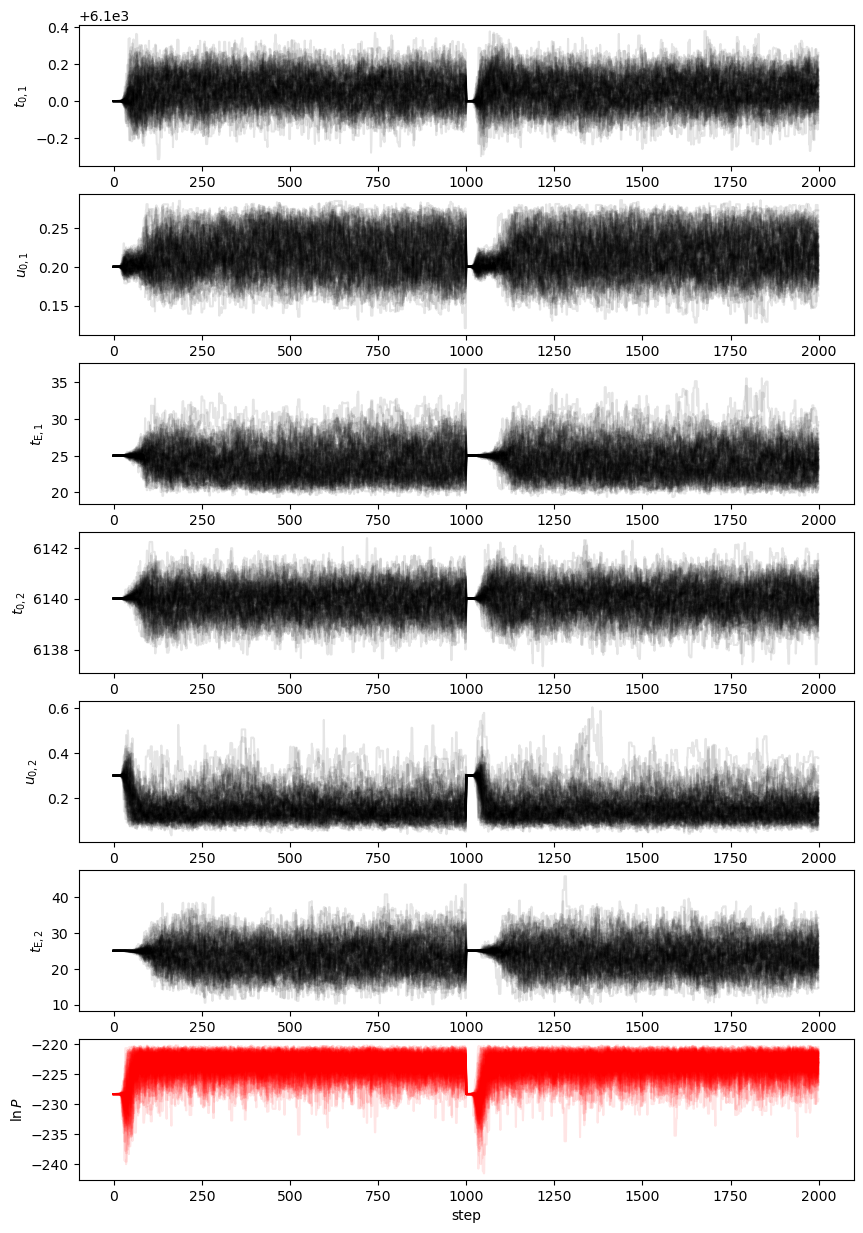

In [28]:
# Function to update the plot
def update_plot(sampler, nwalkers, fig, axes):
    ylabels = [r'$t_{0,1}$', r'$u_{0,1}$', r'$t_{\rm{E},1}$', 
               r'$t_{0,2}$', r'$u_{0,2}$', r'$t_{\rm{E},2}$',
               r'$\ln{P}$']
    for j in range(ndim):
        axes[j].clear()
        for i in range(nwalkers):
            axes[j].plot(sampler.chain[i, :, j], 'k', alpha=0.1)
        axes[j].set_ylabel(ylabels[j])
    
    axes[ndim].clear()
    for i in range(nwalkers):
        axes[ndim].plot(sampler.lnprobability[i], 'r', alpha=0.1)
    axes[ndim].set_ylabel(ylabels[ndim])
    axes[ndim].set_xlabel('step')

    clear_output(wait=True)
    display(fig)
    fig.canvas.draw()
    fig.canvas.flush_events()

# Create the figure and axes
fig, axes = plt.subplots(ndim + 1, 1, figsize=(10, 15));

# Run the sampler in steps and update the plot
i = 0
while i < nsteps:
    if i == 0:
        state = sampler.run_mcmc(initial_pos, steps_between_plot_updates, progress=True)
    else:
        state = sampler.run_mcmc(state, steps_between_plot_updates, progress=True)
    update_plot(sampler, nwalkers, fig, axes)
    i += steps_between_plot_updates
clear_output(wait=True)

# Access the final state
final_state = sampler.get_last_sample().coords

Write your answer here.

Why dont we take a look at the flux parameters for the final state and see if we can figure out what is going on?

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8


<Figure size 640x480 with 0 Axes>

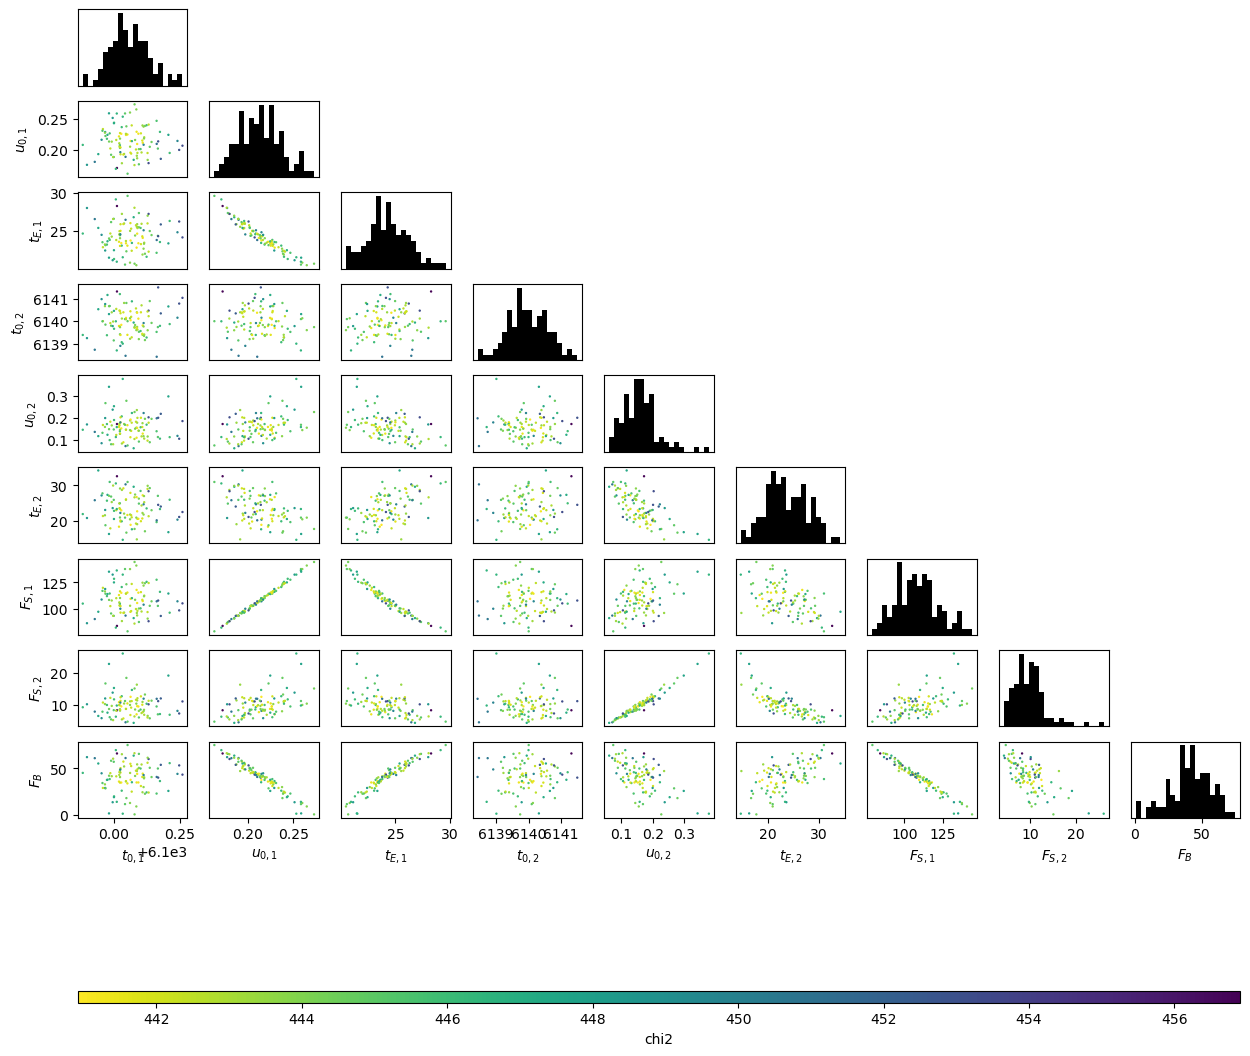

In [45]:
# corner-like scatter plot of final state: u02, t02, FS2, FB

# labels
labels = [r'$t_{0,1}$', r'$u_{0,1}$', r'$t_{E,1}$', r'$t_{0,2}$', r'$u_{0,2}$', r'$t_{E,2}$', r'$F_{S,1}$', r'$F_{S,2}$', r'$F_B$']

# collect the data dor plotting
corner_array = np.zeros((len(final_state), ndim + 4))
corner_array[:, 0:ndim] = final_state

for i in range(len(final_state)):
    chi2, FS1, FS2, FB = binary_source_chi2(final_state[i], model1, model2, data, return_fluxes=True)
    corner_array[i,ndim] = FS1
    corner_array[i,ndim + 1] = FS2
    corner_array[i,ndim + 2] = FB
    corner_array[i,ndim + 3] = chi2

# plot
plt.close(3)
plt.figure(3)
fig, axes = plt.subplots(ndim + 3, ndim + 3, figsize=(15, 15))

for i in range(ndim+3):
    for j in range(ndim+3):
        print(i, j)
        if i > j:  # plot the scatter plots
            scatter = axes[i, j].scatter(corner_array[:, j], 
                                        corner_array[:, i], 
                                        c=corner_array[:, -1], 
                                        cmap='viridis_r', 
                                        s=0.5
                                        )

            if i == ndim + 2:
                axes[i, j].set_xlabel(labels[j])
            else: #turn of ticks labels
                axes[i, j].set_xticks([])

            if j == 0:
                axes[i, j].set_ylabel(labels[i])
            else: #turn of ticks labels
                axes[i, j].set_yticks([])

        elif i == j:  # plot the histograms

            axes[i, j].hist(corner_array[:, j], bins=20, color='k')

            if i == ndim + 2:
                axes[i, j].set_xlabel(labels[j])
            else:
                axes[i, j].set_xticks([])
            
            axes[i, j].set_yticks([])

        else:  # turn off the upper triangle of axis
            axes[i,j].axis('off')


# Add the colorbar using the scatter plot object
cbar = fig.colorbar(scatter, orientation='horizontal', ax=axes, aspect=100)
cbar.set_label('chi2')

plt.show()

Do you see the problem? Negative blend-flux values are allowing for very high $F_{\rm{S},2}$ values, in combination with very low $t_{\rm{E},2}$ and very high $u_{0,2}$. We can avoid this problem by not allowing negative blending, which, considering our data was generated without using photometry, makes absolutely no sense. For events found in real data a small negative flux can be plausible as it is an indication that the "zero flux" background-level in the photometry was actually measureing some flux from stars. In these cases, the blend flux should actually have been measured as very small or 0. 

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 7</h2>
    <p>Add a prior on blend flux in <i>ln_prob()</i> function (Exercies 3) and any other priors you think seem reasonable.</p>
    <br>
</div>

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise -1</h2>
    <p>Which binary-lens models have degenerate, binary-source, counter parts? </p>
    <br>
</div>

Write your answer here

Binary source events can throw a real spanner in the works when it comes to event modelling. Not only can they mimic caustic purturbations with a finite source effect, but they can also mess with colour-colour inference between observatories such as contemporaneous space-based observations, or late-time follow-up lens-flux and astrometric observations. With binaries possibly making up 40% or more of the stars in the Galactic centre ([Gautam et al., 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...964..164G); [McTier, Kipping, & Johnston, 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.495.2105M)), this potential complication is not one that should be ignored.

## Next steps

Well, you've been warned. Now let's more on to something else. Maybe to one of these:
+ [Binary lenses](BinaryLens.ipynb)
+ [Higher-order effects]()
+ [The Galactic model](GalacticModel.ipynb)
+ [Modelling](Modelling.ipynb).

Okay, bye. I'll see you there.
